In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("SVM Binary Classification Implementation")


# 1. Load and prepare the dataset
print("\n1. Loading and Preparing Dataset")


# Load the dataset
try:
    # Try to load from file first
    data = pd.read_csv('breast-cancer.csv')
    print(f"Dataset loaded successfully from file!")
    print(f"Dataset shape: {data.shape}")
except FileNotFoundError:
    print("Dataset file not found. Using sklearn's built-in breast cancer dataset...")
    from sklearn.datasets import load_breast_cancer
    
    # Load sklearn's breast cancer dataset
    cancer_data = load_breast_cancer()
    data = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
    data['diagnosis'] = cancer_data.target
    
    # Convert target to match expected format (M=1, B=0)
    data['diagnosis'] = data['diagnosis'].map({1: 'M', 0: 'B'})
    
    print(f"Using sklearn breast cancer dataset")
    print(f"Dataset shape: {data.shape}")

# Display basic information about the dataset
print(f"\nDataset Info:")
print(f"Number of samples: {len(data)}")
print(f"Number of features: {data.shape[1] - 1}")
print(f"Target distribution:")
print(data['diagnosis'].value_counts())

# Display first few rows
print(f"\nFirst 5 rows:")
print(data.head())

# Check for missing values
print(f"\nMissing values per column:")
print(data.isnull().sum().sum())

SVM Binary Classification Implementation

1. Loading and Preparing Dataset
Dataset loaded successfully from file!
Dataset shape: (569, 32)

Dataset Info:
Number of samples: 569
Number of features: 31
Target distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64

First 5 rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2   

In [2]:
# Separate features and target
X = data.drop(['diagnosis'], axis=1)
if 'id' in X.columns:
    X = X.drop(['id'], axis=1)

y = data['diagnosis']

# Convert target to binary (M=1, B=0)
y = y.map({'M': 1, 'B': 0})

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution after encoding: {y.value_counts().to_dict()}")

# Select top features for 2D visualization (we'll use mean radius and mean texture)
X_2d = X[['mean radius', 'mean texture']] if 'mean radius' in X.columns else X.iloc[:, [0, 1]]
feature_names_2d = X_2d.columns.tolist()

print(f"Selected features for 2D visualization: {feature_names_2d}")

Features shape: (569, 30)
Target shape: (569,)
Target distribution after encoding: {0: 357, 1: 212}
Selected features for 2D visualization: ['radius_mean', 'texture_mean']


In [3]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 455
Test set size: 114


In [4]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_2d = StandardScaler()
X_train_2d_scaled = scaler_2d.fit_transform(X_train_2d)
X_test_2d_scaled = scaler_2d.transform(X_test_2d)

print("Features scaled successfully using StandardScaler")


Features scaled successfully using StandardScaler


In [5]:

# Linear SVM
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)

# Predictions
y_pred_linear = svm_linear.predict(X_test_scaled)

# Performance
accuracy_linear = accuracy_score(y_test, y_pred_linear)
print(f"Linear SVM Accuracy: {accuracy_linear:.4f}")


Linear SVM Accuracy: 0.9649


In [6]:

# RBF SVM
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)

# Predictions
y_pred_rbf = svm_rbf.predict(X_test_scaled)

# Performance
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"RBF SVM Accuracy: {accuracy_rbf:.4f}")


RBF SVM Accuracy: 0.9737


In [7]:

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# Grid search
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Best model
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best SVM Test Accuracy: {accuracy_best:.4f}")


Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.9758
Best SVM Test Accuracy: 0.9737


In [8]:

# Perform cross-validation for all models
cv_scores_linear = cross_val_score(svm_linear, X_train_scaled, y_train, cv=5)
cv_scores_rbf = cross_val_score(svm_rbf, X_train_scaled, y_train, cv=5)
cv_scores_best = cross_val_score(best_svm, X_train_scaled, y_train, cv=5)

print(f"Linear SVM CV Scores: {cv_scores_linear}")
print(f"Linear SVM CV Mean: {cv_scores_linear.mean():.4f} (+/- {cv_scores_linear.std() * 2:.4f})")

print(f"\nRBF SVM CV Scores: {cv_scores_rbf}")
print(f"RBF SVM CV Mean: {cv_scores_rbf.mean():.4f} (+/- {cv_scores_rbf.std() * 2:.4f})")

print(f"\nBest SVM CV Scores: {cv_scores_best}")
print(f"Best SVM CV Mean: {cv_scores_best.mean():.4f} (+/- {cv_scores_best.std() * 2:.4f})")


Linear SVM CV Scores: [0.96703297 0.98901099 0.94505495 0.96703297 0.94505495]
Linear SVM CV Mean: 0.9626 (+/- 0.0329)

RBF SVM CV Scores: [0.96703297 1.         0.96703297 0.96703297 0.97802198]
RBF SVM CV Mean: 0.9758 (+/- 0.0256)

Best SVM CV Scores: [0.96703297 1.         0.96703297 0.96703297 0.97802198]
Best SVM CV Mean: 0.9758 (+/- 0.0256)


In [9]:

print("Best SVM Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Benign', 'Malignant']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)


Best SVM Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        72
   Malignant       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


Confusion Matrix:
[[72  0]
 [ 3 39]]


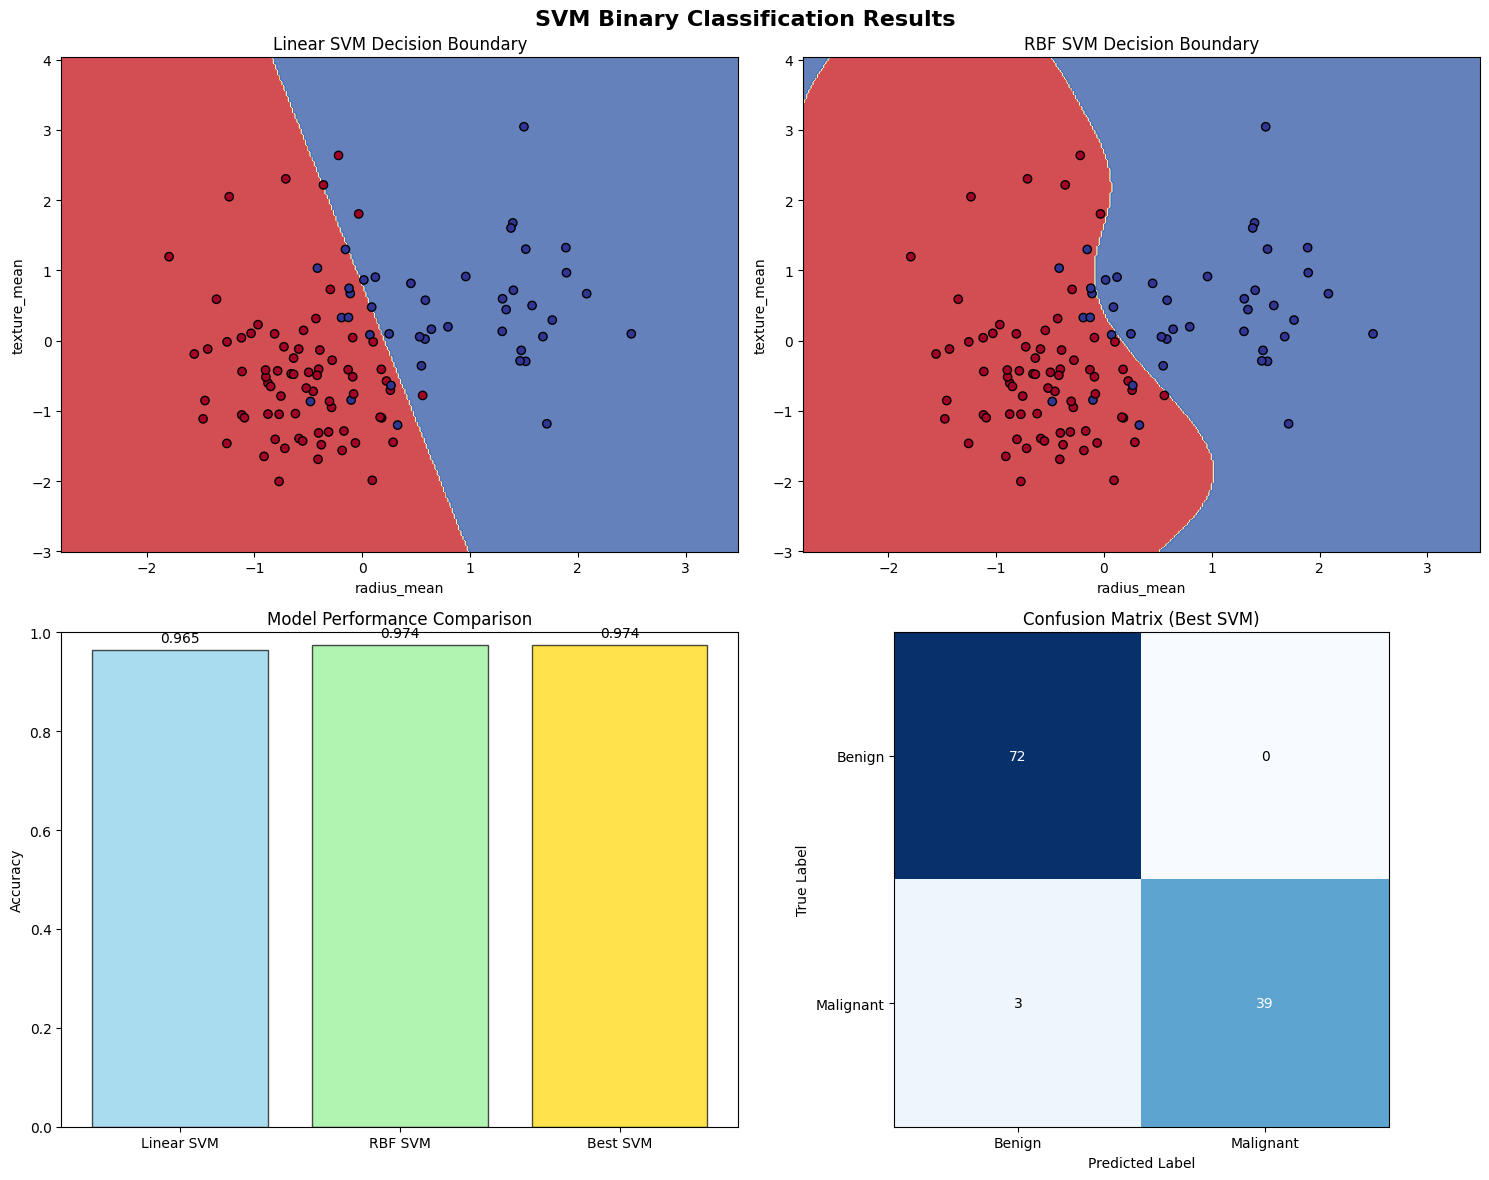

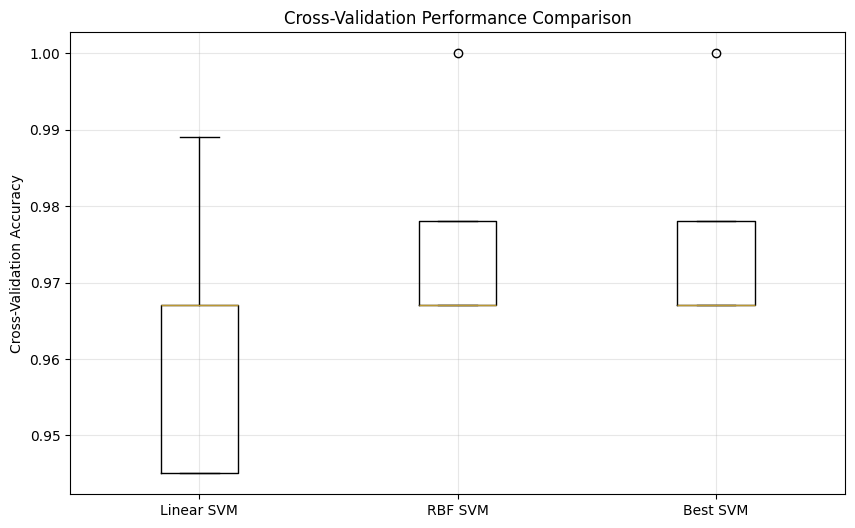

In [10]:

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('SVM Binary Classification Results', fontsize=16, fontweight='bold')

# Plot 1: Decision Boundary for Linear SVM (2D)
svm_linear_2d = SVC(kernel='linear', random_state=42)
svm_linear_2d.fit(X_train_2d_scaled, y_train_2d)

def plot_decision_boundary(X, y, model, ax, title):
    # Create a mesh
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Make predictions on the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    
    # Plot the data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    ax.set_xlabel(feature_names_2d[0])
    ax.set_ylabel(feature_names_2d[1])
    ax.set_title(title)
    return scatter

# Linear SVM decision boundary
scatter1 = plot_decision_boundary(X_test_2d_scaled, y_test_2d, svm_linear_2d, axes[0, 0], 'Linear SVM Decision Boundary')

# RBF SVM decision boundary
svm_rbf_2d = SVC(kernel='rbf', random_state=42)
svm_rbf_2d.fit(X_train_2d_scaled, y_train_2d)
scatter2 = plot_decision_boundary(X_test_2d_scaled, y_test_2d, svm_rbf_2d, axes[0, 1], 'RBF SVM Decision Boundary')

# Plot 2: Model Comparison
models = ['Linear SVM', 'RBF SVM', 'Best SVM']
accuracies = [accuracy_linear, accuracy_rbf, accuracy_best]
colors = ['skyblue', 'lightgreen', 'gold']

bars = axes[1, 0].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Model Performance Comparison')
axes[1, 0].set_ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')

# Plot 3: Confusion Matrix Heatmap
im = axes[1, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1, 1].set_title('Confusion Matrix (Best SVM)')
tick_marks = np.arange(2)
axes[1, 1].set_xticks(tick_marks)
axes[1, 1].set_yticks(tick_marks)
axes[1, 1].set_xticklabels(['Benign', 'Malignant'])
axes[1, 1].set_yticklabels(['Benign', 'Malignant'])

# Add text annotations
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black")

axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Additional visualization: Cross-validation scores
plt.figure(figsize=(10, 6))
cv_results = [cv_scores_linear, cv_scores_rbf, cv_scores_best]
labels = ['Linear SVM', 'RBF SVM', 'Best SVM']

plt.boxplot(cv_results, labels=labels)
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Performance Comparison')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
print(f" Dataset: Breast Cancer Classification")
print(f" Best Model: {grid_search.best_params_}")
print(f" Best Accuracy: {accuracy_best:.4f}")
print(f" Cross-Validation Score: {cv_scores_best.mean():.4f} (+/- {cv_scores_best.std() * 2:.4f})")
print(f" Key Insights:")
print(f"  • Linear SVM achieved {accuracy_linear:.4f} accuracy")
print(f"  • RBF SVM achieved {accuracy_rbf:.4f} accuracy") 
print(f"  • Hyperparameter tuning improved performance to {accuracy_best:.4f}")
print(f"  • The model successfully separates malignant from benign tumors")


 Dataset: Breast Cancer Classification
 Best Model: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
 Best Accuracy: 0.9737
 Cross-Validation Score: 0.9758 (+/- 0.0256)
 Key Insights:
  • Linear SVM achieved 0.9649 accuracy
  • RBF SVM achieved 0.9737 accuracy
  • Hyperparameter tuning improved performance to 0.9737
  • The model successfully separates malignant from benign tumors
